# Pneumonia Detection Model

This Jupyter Notebook contains code for training a deep learning model to detect pneumonia in medical images using a pre-trained ResNet50 model.


In [94]:
#imports 
import glob as gb
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np


## Data Preparation

In this section, we prepare the dataset for training and validation. We define the paths to the dataset directories, set image dimensions, and create TensorFlow Dataset objects for training, validation, and testing.


In [56]:
# import the data set
train_path = 'dataset/train'
validate_path = 'dataset/val/'
dataset_test = 'dataset/test/'

In [57]:
#set some variables before we go ahead
image_height = 227
image_width = 227
batch_size = 10

In [58]:
training_data = keras.preprocessing.image_dataset_from_directory(
    train_path,
    batch_size = 10,
    image_size =(227,227),

    shuffle = True,
    seed =123,
    subset ='training',
    validation_split=0.15
    )
validation_data =keras.preprocessing.image_dataset_from_directory(
    validate_path,
    batch_size = 10,
    image_size =(227,227),

    shuffle = True,
    seed =123,
    validation_split =0.15,
    subset ='validation'
    
    )

dataset_test = tf.keras.preprocessing.image_dataset_from_directory(dataset_test, 
                                                                    image_size = (227,227),
                                                                    batch_size = batch_size
                                                                   )

Found 5216 files belonging to 2 classes.
Using 4434 files for training.
Found 16 files belonging to 2 classes.
Using 2 files for validation.
Found 624 files belonging to 2 classes.


## Visualization Functions

These functions are used to visualize the dataset, predictions, and training metrics.


In [99]:
class_names = ['normal','pneumonia']

def plot_dataset(dataset):
    plt.gcf().clear()
    plt.figure(figsize=(10,10))
    
    for features, labels in dataset.take(1):
        for i in range(9):
            
            plt.subplot(3,3,i+1)
            plt.title('off')
            
            plt.imshow(features[i].numpy().astype('uint8'))
            plt.title(class_names[labels[i]])

<Figure size 640x480 with 0 Axes>

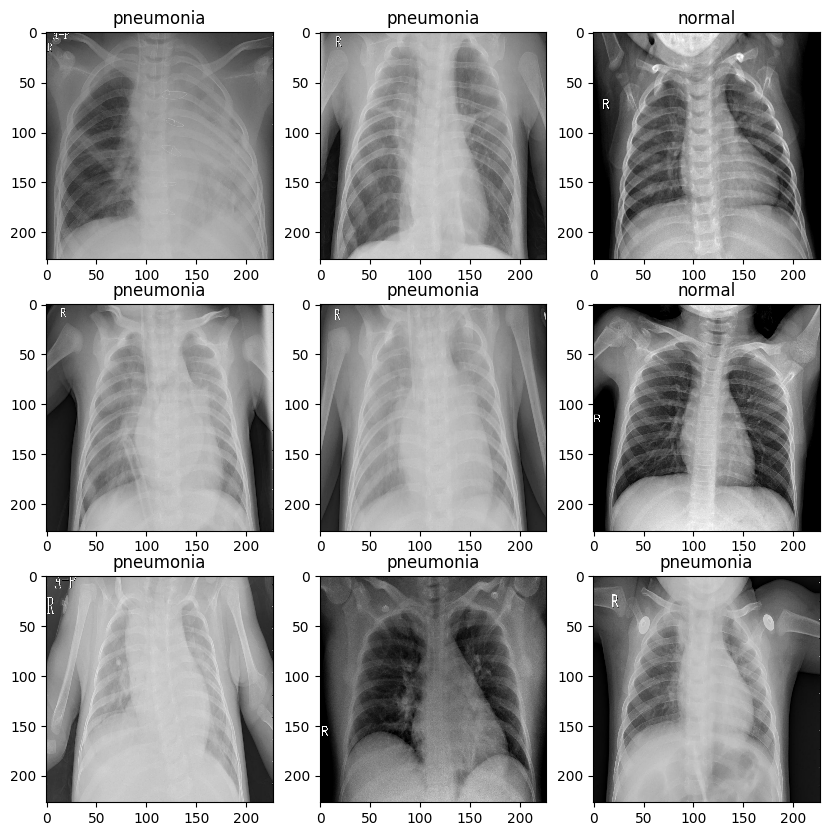

In [80]:
plot_dataset(training_data)

## Model Building

Here, we define the architecture of our deep learning model. We load a pre-trained ResNet50 model, freeze its layers, and add custom layers for binary classification. The model is compiled with the specified loss and optimizer.


In [41]:
resnet_model = Sequential()

pretrained_model= keras.applications.ResNet50(include_top=False,
                   input_shape=(227,227,3),
                   pooling='avg',classes=5,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(2, activation='softmax'))

In [42]:
resnet_model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.SGD(lr=0.0009), metrics=['accuracy'])

## Early Stopping

We use the EarlyStopping callback to monitor the validation loss during training and stop training if it doesn't improve for a certain number of epochs. This helps prevent overfitting.


In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)


## Model Training

In this section, we train the model using the training and validation datasets. We specify the number of epochs and use the EarlyStopping callback to control training.


In [68]:

# Training with early stopping
epochs = 10

history = resnet_model.fit(
    training_data,
    validation_data=validation_data,
    epochs=epochs,
    callbacks=[early_stopping]  # Pass the EarlyStopping callback
)

Epoch 1/10


444/444 [==============================] - 124s 278ms/step - loss: 0.0379 - accuracy: 0.9867 - val_loss: 3.0398e-05 - val_accuracy: 1.0000
Epoch 2/10
444/444 [==============================] - 125s 282ms/step - loss: 0.0345 - accuracy: 0.9880 - val_loss: 1.0669e-05 - val_accuracy: 1.0000
Epoch 3/10
444/444 [==============================] - 133s 298ms/step - loss: 0.0293 - accuracy: 0.9903 - val_loss: 2.9206e-06 - val_accuracy: 1.0000
Epoch 4/10
444/444 [==============================] - 124s 279ms/step - loss: 0.0310 - accuracy: 0.9901 - val_loss: 2.0265e-05 - val_accuracy: 1.0000
Epoch 5/10
444/444 [==============================] - 118s 265ms/step - loss: 0.0243 - accuracy: 0.9932 - val_loss: 1.1384e-05 - val_accuracy: 1.0000
Epoch 6/10
444/444 [==============================] - 116s 262ms/step - loss: 0.0251 - accuracy: 0.9926 - val_loss: 3.8147e-06 - val_accuracy: 1.0000


## Plotting Dataset and Predictions

We use these functions to visualize sample images from the dataset and make predictions on the test dataset, providing visual confirmation of the model's performance.


1/1 [==============================] - 0s 310ms/step


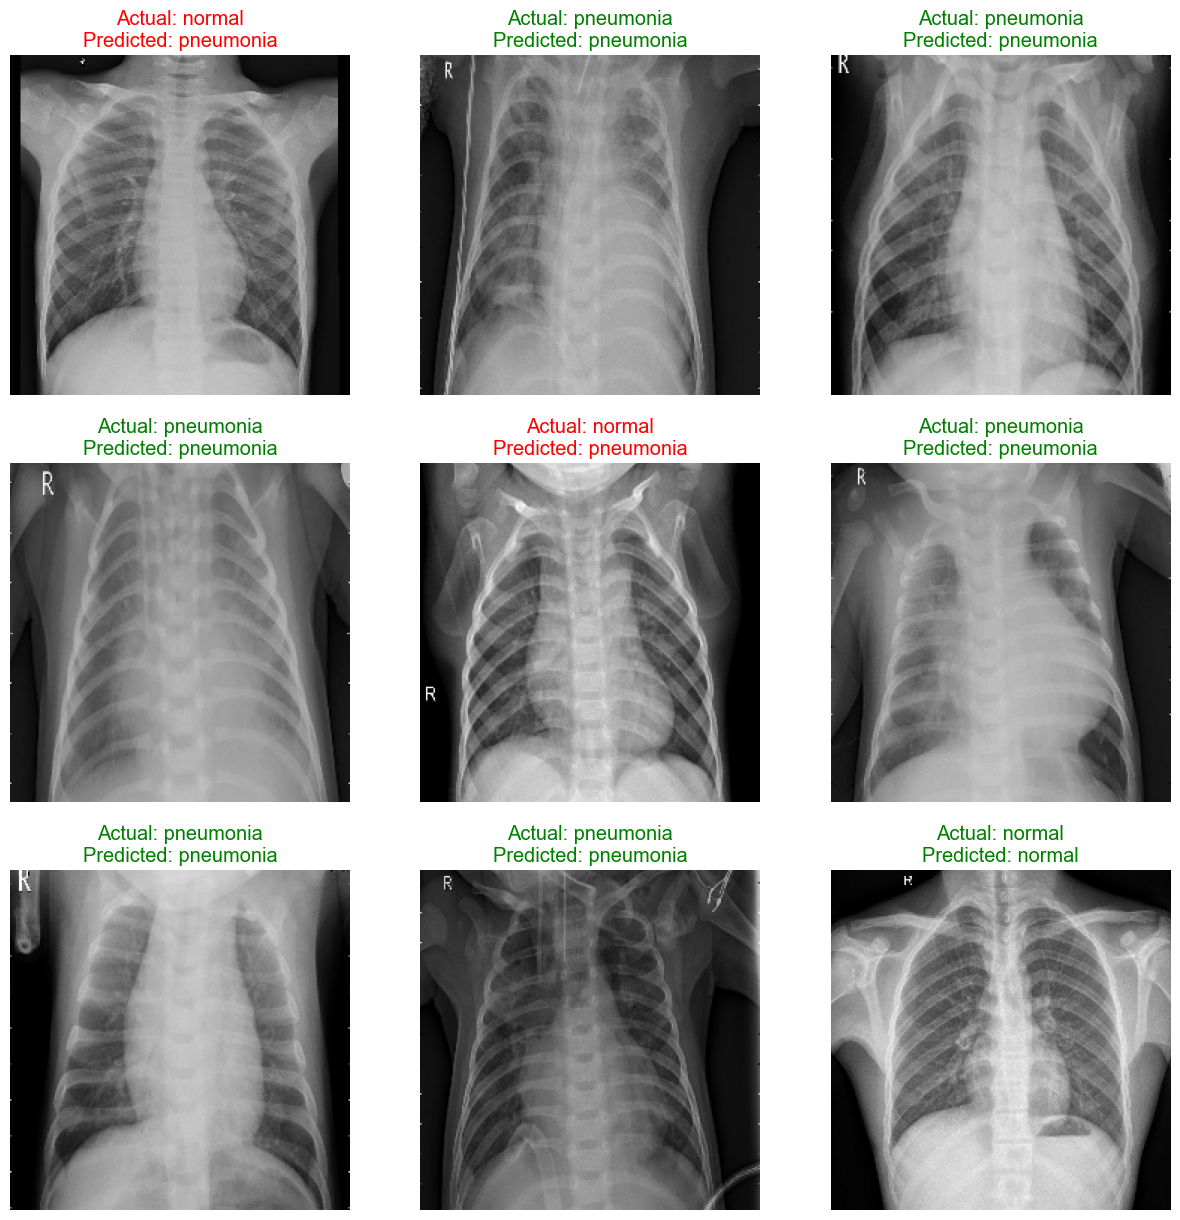

In [107]:
y_true = []
y_pred = []

def plot_actual_vs_predicted(dataset, model, class_names):
    plt.figure(figsize=(15, 15))
    batch_size = 9  # Number of images to display
    num_classes = len(class_names)

    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        for i in range(batch_size):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))

            actual_label = class_names[labels[i]]
            predicted_label = class_names[np.argmax(predictions[i])]
            
            y_true = actual_label
            y_pred = predicted_label
            
            # Color the title based on correct or incorrect prediction
            title_color = "green" if actual_label == predicted_label else "red"
            
            plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}", color=title_color)
            plt.axis("off")

# Usage example:
class_names = ['normal', 'pneumonia']
plot_actual_vs_predicted(dataset_test, resnet_model, class_names)


## Plotting Model Metrics

These plots show the training and validation accuracy and loss over epochs, providing insights into the model's training progress.


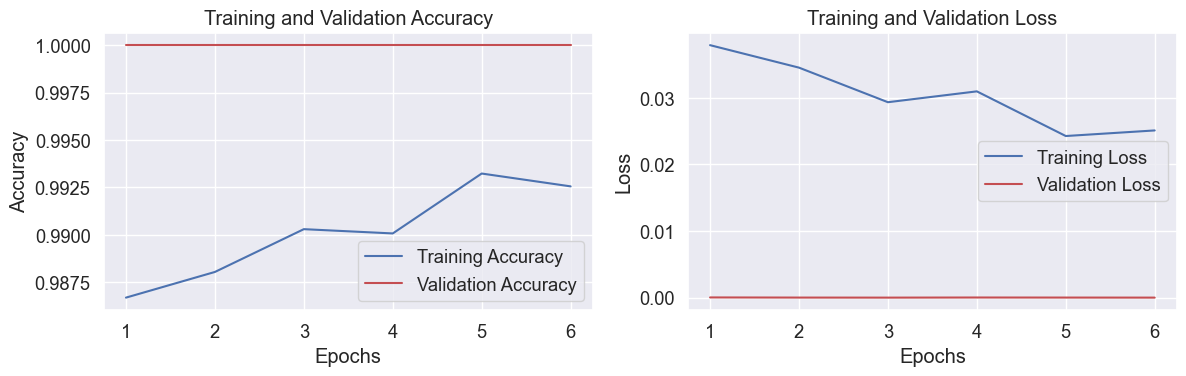

In [108]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    # Extract training history
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(accuracy) + 1)

    # Plot Accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Usage example
plot_metrics(history)  # Pass your training history object to this function


In [109]:
# ... (previous code) ...

# Import the additional libraries
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# ... (previous code) ...

# Define the function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create a heatmap
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    
    # Display classification report
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("Classification Report:\n", report)

# ... (previous code) ...

# After training your model, you can use the function to plot the confusion matrix
# Example usage:
class_names = ['normal', 'pneumonia']

# Replace y_true and y_pred with your actual data
# You should have actual labels (y_true) and predicted labels (y_pred) from your test set
# y_true = [...]  # Replace with your true labels
# y_pred = [...]  # Replace with your predicted labels

# plot_confusion_matrix(y_true, y_pred, class_names)

# ... (remaining code) ...


Classification Report:
               precision    recall  f1-score   support

      normal       1.00      1.00      1.00         5
   pneumonia       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



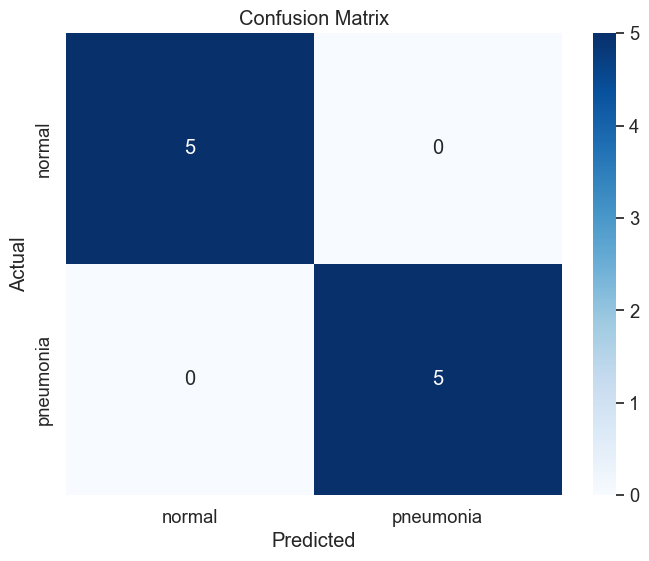

In [ ]:
plot_confusion_matrix(y_true,y_pred, class_names)